In [1]:
from ecgdigitize.image import *
from pathlib import Path
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from ecgdigitize.ecgdigitize import estimateRotationAngle
from ecgdigitize.grid import frequency as grid_frequency
from ecgdigitize import common, otsu, vision
from ecgdigitize.signal.extraction import viterbi

In [2]:


def _gridIsDetectable(image: BinaryImage) -> bool:
    columnDensity = np.sum(image.data, axis=0)
    columnFrequencyStrengths = common.autocorrelation(columnDensity)
    columnFrequency = grid_frequency._estimateFirstPeakLocation(
        columnFrequencyStrengths,
        interpolate=False
    )

    return not columnFrequency is None

def adaptive(image: ColorImage, applyDenoising: bool = False) -> BinaryImage:
    maxHedge = 1
    minHedge = 0.4  # 0.5

    grayscaleImage = image.toGrayscale()
    otsuThreshold = otsu.otsuThreshold(grayscaleImage)

    hedging = float(maxHedge)
    binary = grayscaleImage.toBinary(otsuThreshold * hedging)

    while _gridIsDetectable(binary):
        hedging -= 0.05  # TODO: More intelligent choice of step
        if hedging < minHedge:
            break

        binary = grayscaleImage.toBinary(otsuThreshold * hedging)
    
    return binary

In [3]:
def digitizeSignal(image: ColorImage) -> Union[np.ndarray, common.Failure]:
    
    # First, convert color image to binary image where signal pixels are turned on (1) and other are off (0)
    binary = adaptive(image)

    # Second, analyze the binary image to produce a signal
    signal = viterbi.extractSignal(binary)

    return signal


In [4]:
path1 = 'sample.png'
img1 = openImage(Path(path1))

path2 = 'row2.jpg'
img2 = openImage(Path(path2))


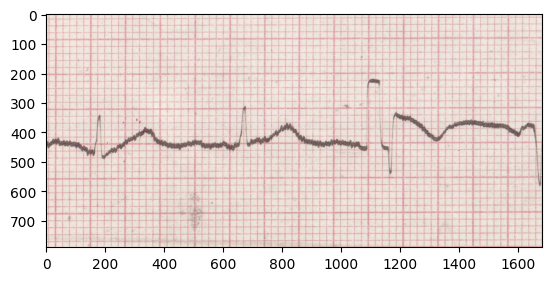

In [5]:
plt.imshow(img1.data[:, :, ::-1])

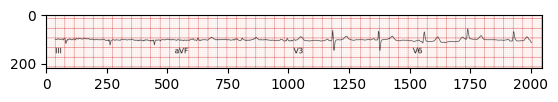

In [6]:
plt.imshow(img2.data[:, :, ::-1])

In [7]:
def thresholdApproach(colorImage: ColorImage, erode: bool =False) -> BinaryImage:
    binaryImage = allDarkPixels(colorImage)

    signalImage = adaptive(colorImage)

    dilatedSignal = cv2.dilate(
        signalImage.data,
        cv2.getStructuringElement(cv2.MORPH_DILATE, (5,5))
    )

    subtracted: np.ndarray = cv2.subtract(binaryImage.data, dilatedSignal)

    # <- DEBUG ->
    # from ..visualization import displayImage
    # displayImage(BinaryImage(subtracted).toColor())

    if erode:
        final = cv2.erode(
            subtracted,
            cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))
        )
        return BinaryImage(final)
    else:
        return BinaryImage(subtracted)


def allDarkPixels(colorImage: ColorImage, belowThreshold: int = 230) -> BinaryImage:
    grayscale = colorImage.toGrayscale()

    # Adjusts the exposure of the image so that the most common pixel is pure white
    # This helps to normalize for variation in the greyness of the paper
    adjusted = grayscale.whitePointAdjusted()
    # print(adjusted.data)

    # Now that we have applied some normalization,
    binary = adjusted.toBinary(belowThreshold)

    # print(binary.data)
    # import matplotlib.pyplot as plt
    # # plt.imshow(adjusted.data)
    # plt.imshow(binary.data)
    # plt.pause(3)

    return binary

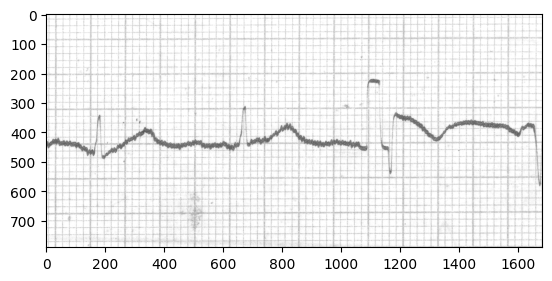

In [8]:
gray1 = img1.toGrayscale().whitePointAdjusted()
gray2 = img2.toGrayscale().whitePointAdjusted()

plt.imshow(gray1.data, cmap='gray', vmin=0, vmax=255)

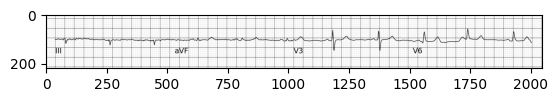

In [9]:
plt.imshow(gray2.data, cmap='gray', vmin=0, vmax=255)

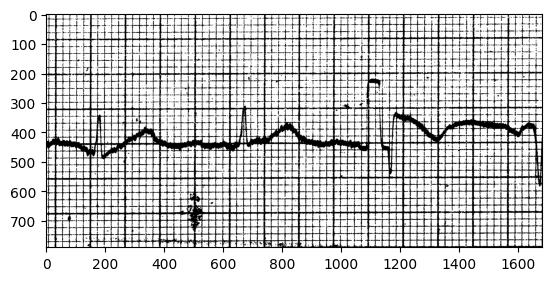

In [10]:
thres = 230
bin1 = gray1.toBinary(thres, inverse=False)
bin2 = gray2.toBinary(thres, inverse=False)

plt.imshow(bin1.data, cmap='gray')

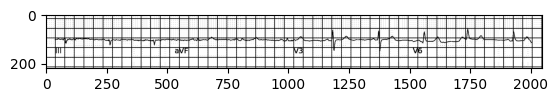

In [11]:
plt.imshow(bin2.data, cmap='gray')

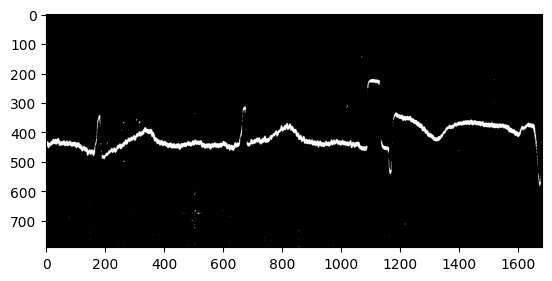

In [12]:
sig1 = adaptive(img1)
sig2 = adaptive(img2)
plt.imshow(sig1.data, cmap='gray')

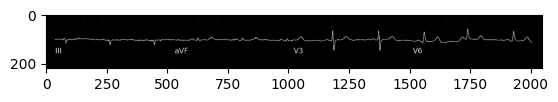

In [13]:
plt.imshow(sig2.data, cmap='gray') # TODO: grid is still visible

In [14]:
dilated1 = cv2.dilate(
    sig1.data,
    cv2.getStructuringElement(cv2.MORPH_DILATE, (5,5))
)

dilated2 = cv2.dilate(
    sig2.data,
    cv2.getStructuringElement(cv2.MORPH_DILATE, (5,5))
)

subtracted1 = BinaryImage(cv2.subtract(bin1.data, dilated1))
subtracted2 = BinaryImage(cv2.subtract(bin2.data, dilated2))

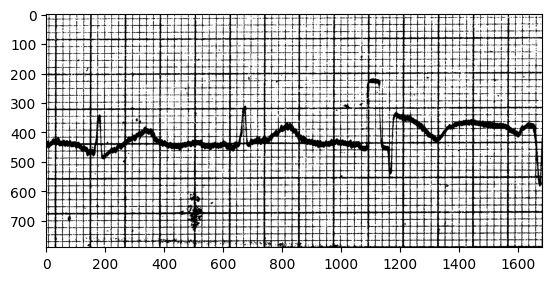

In [15]:
plt.imshow(subtracted1.data, cmap='gray')

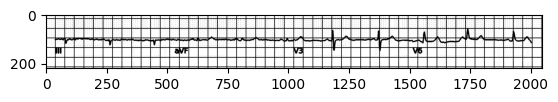

In [16]:
plt.imshow(subtracted2.data, cmap='gray') 

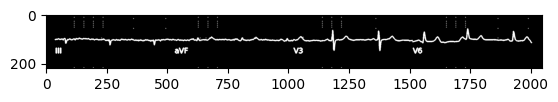

In [17]:
plt.imshow(dilated2, cmap='gray')

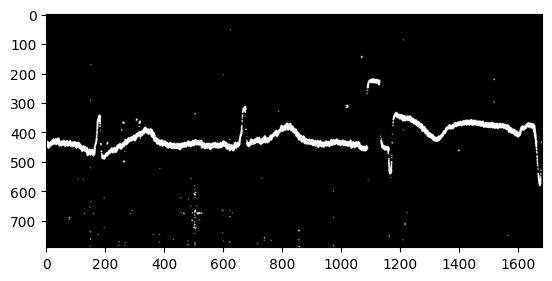

In [18]:
plt.imshow(dilated1, cmap='gray')

None adjacent to Point(x=37, y=104)


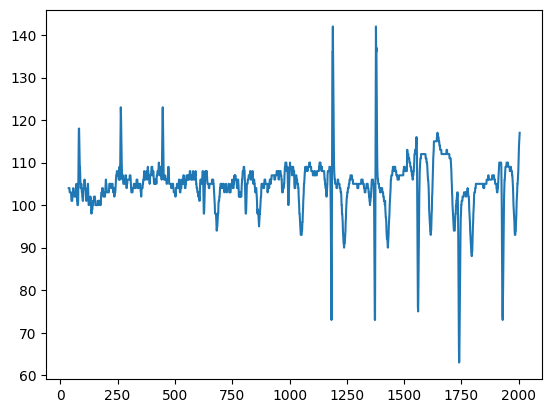

In [19]:
signal2 = viterbi.extractSignal(sig2)
plt.plot(signal2)